## Evaluation of the Results 

This jupyter notebook contains the code to evaluate the simulation results obatined. 
1. Data for each Block is gathered 
2. Data for each Block is compared, measured, results, CVRMSE, e.g. 
3. Data is plotted for 

In [21]:
import os
import geopandas as gpd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

<Axes: >

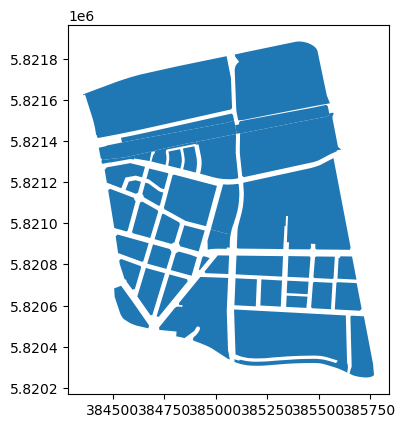

In [22]:
# Load Block level data 
block_data = gpd.read_file(r'auxillary\00_block_shape.shp')
block_data.plot()

<Axes: >

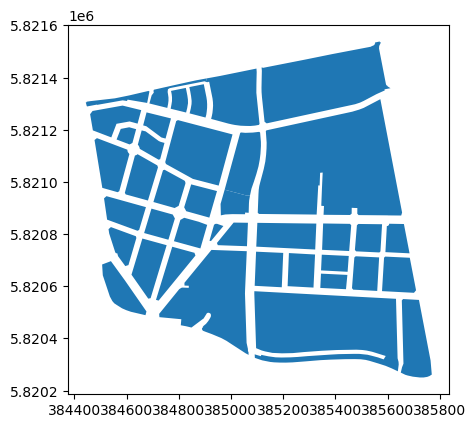

In [23]:
# Get the relevant blocks at the innner mierendorff Insel
outer_mierendorff = ["019609", "019017", "019808", "019901", "020902", "019708"]
block_data['blknr'] = block_data["blknr"].astype(str)
block_data = block_data[~block_data["blknr"].isin(outer_mierendorff)]
block_data.plot()

<Axes: >

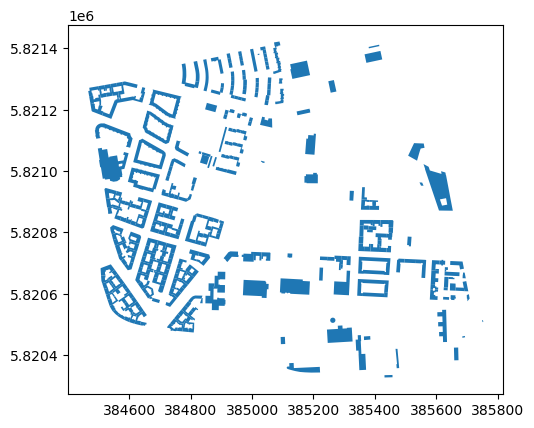

In [24]:
# Load Building level data and shape file
CEA_shape_path = os.path.join('CEA_model', 'DefaultModel', '2020_GER_Updated', 'inputs', 'building-geometry' ,'zone.shp')
CEA_shape = gpd.read_file(CEA_shape_path)
CEA_shape.plot()

In [25]:
CEA_shape = CEA_shape.to_crs(block_data.crs)

In [26]:
# Perform spatial join to find which block each building in CEA_shape belongs to
buildings_with_block = gpd.sjoin(CEA_shape, block_data, how="inner", op='intersects')

# Filter by building Name (replace 'YourBuildingName' with the actual building name)
building_block = buildings_with_block[buildings_with_block['Name'] == 'B1000']

# Assuming 'blknr' is a column in block_data indicating the block number
block_number = building_block['blknr'].unique()

print(f"Building is in block number(s): {block_number}")

Building is in block number(s): ['020055']


c:\Users\felix\anaconda3\envs\cea\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
# Gather CEA simulation results
import pandas as pd 
import os 

data_dict = {
    "QH_sys_MWhyr": {},
    "E_sys_MWhyr": {}
}
#C:\Users\felix\Documents\Programmieren\Mierendorff_CEA\CEA_model\DefaultModel\2020_GER_Updated\outputs\data\demand\B1000.csv
#CEA_model\\Default_Model2020_GER_Updated\\outputs\\data\\demand\\Total_demand.csv

QH_dict = {}
base_path = 'CEA_model/Block0202023'
block_numbers = list(block_data["blknr"])
# Gather CEA simulation results
import pandas as pd 
import os 

data_dict = {
    
}

block_numbers = list(block_data["blknr"])
# Initialize data_dict with keys for each year and energy type
data_dict = {
    'blknr': [],
    'QH_sys_MWhyr_2020': [],
    'QH_sys_MWhyr_2021': [],
    'QH_sys_MWhyr_2022': [],
    'E_sys_MWhyr_2020': [],
    'E_sys_MWhyr_2021': [],
    'E_sys_MWhyr_2022': []
}

block_numbers = list(block_data["blknr"])
for block_number in block_numbers:
    buildings_in_block = buildings_with_block[buildings_with_block['blknr'] == block_number]
    if buildings_in_block.empty:
            continue
    else:
         data_dict['blknr'].append(block_number)
         for year in [2020, 2021, 2022]:
            path = os.path.join('CEA_model', 'DefaultModel', f'{year}_GER_Updated', 'outputs', 'data', 'demand', 'Total_demand.csv')
            df = pd.read_csv(path)
            # Extract building names into a list
            building_names = buildings_in_block['Name'].tolist()  # Assuming 'Name' is the column with building names
            filtered_df = df[df['Name'].isin(building_names)]
            
            # Append the block number and aggregated values to their respective lists in data_dict
            
            data_dict[f"QH_sys_MWhyr_{year}"].append(filtered_df["QH_sys_MWhyr"].sum())
            data_dict[f"E_sys_MWhyr_{year}"].append(filtered_df["E_sys_MWhyr"].sum())


In [28]:
# Assuming data_dict is already defined as per your previous instructions
simulation_data = pd.DataFrame(data_dict, columns=data_dict.keys())
simulation_merged_gdf = gpd.GeoDataFrame(pd.merge(block_data, simulation_data, on='blknr', how='left'))

In [29]:
# Load Measured Data for electricity
elec_data = pd.read_excel(r'auxillary\Elec_Berlin_2020_2022.xls')
gas_data = pd.read_excel(r'auxillary\Gas_Berlin_2020_2022.xls')
dh_data = pd.read_excel(r'auxillary\DH_Berlin_2020_2022.xls')
block_data["blknr"] = block_data["blknr"].astype(int)   

dh_data = dh_data.rename(columns={"Blocknummer": "blknr"})
dh_data_shapes = block_data.merge(dh_data, on='blknr', how='left')
elec_data = elec_data.rename(columns={"Blocknummer": "blknr"})  
elec_data_shapes = block_data.merge(elec_data, on='blknr', how='left')
gas_data = gas_data.rename(columns={"Blocknummer": "blknr"})
gas_data_shapes = block_data.merge(gas_data, on='blknr', how='left')

In [32]:
# Adjust types 
# Code from: https://github.com/TUB-DVG/TECDEM/blob/main/experiments/81_PlotBlock.ipynb 
elec_columns_to_check = [
        "Stromverbrauch 2022 [MWh]",
        "Stromverbrauch 2021 [MWh]",
        "Stromverbrauch 2020 [MWh]"
    ]

for column in elec_columns_to_check:
        elec_data_shapes[column] = pd.to_numeric(elec_data_shapes[column], errors='coerce')

elec_data_shapes["valid_entries"] = elec_data_shapes[elec_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

gas_columns_to_check = [
        "Gasverbrauch 2022 [MWh]",
        "Gasverbrauch 2021 [MWh]",
        "Gasverbrauch 2020 [MWh]"
    ]

for column in gas_columns_to_check:
        gas_data_shapes[column] = pd.to_numeric(gas_data_shapes[column], errors='coerce')

gas_data_shapes["valid_entries"] = gas_data_shapes[gas_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

dh_columns_to_check = [
        "Fernwärmeverbrauch 2022 [MWh]",
        "Fernwärmeverbrauch 2021 [MWh]",
        "Fernwärmeverbrauch 2020 [MWh]"
    ]

for column in dh_columns_to_check:
        dh_data_shapes[column] = pd.to_numeric(dh_data_shapes[column], errors='coerce')

dh_data_shapes["valid_entries"] = dh_data_shapes[dh_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

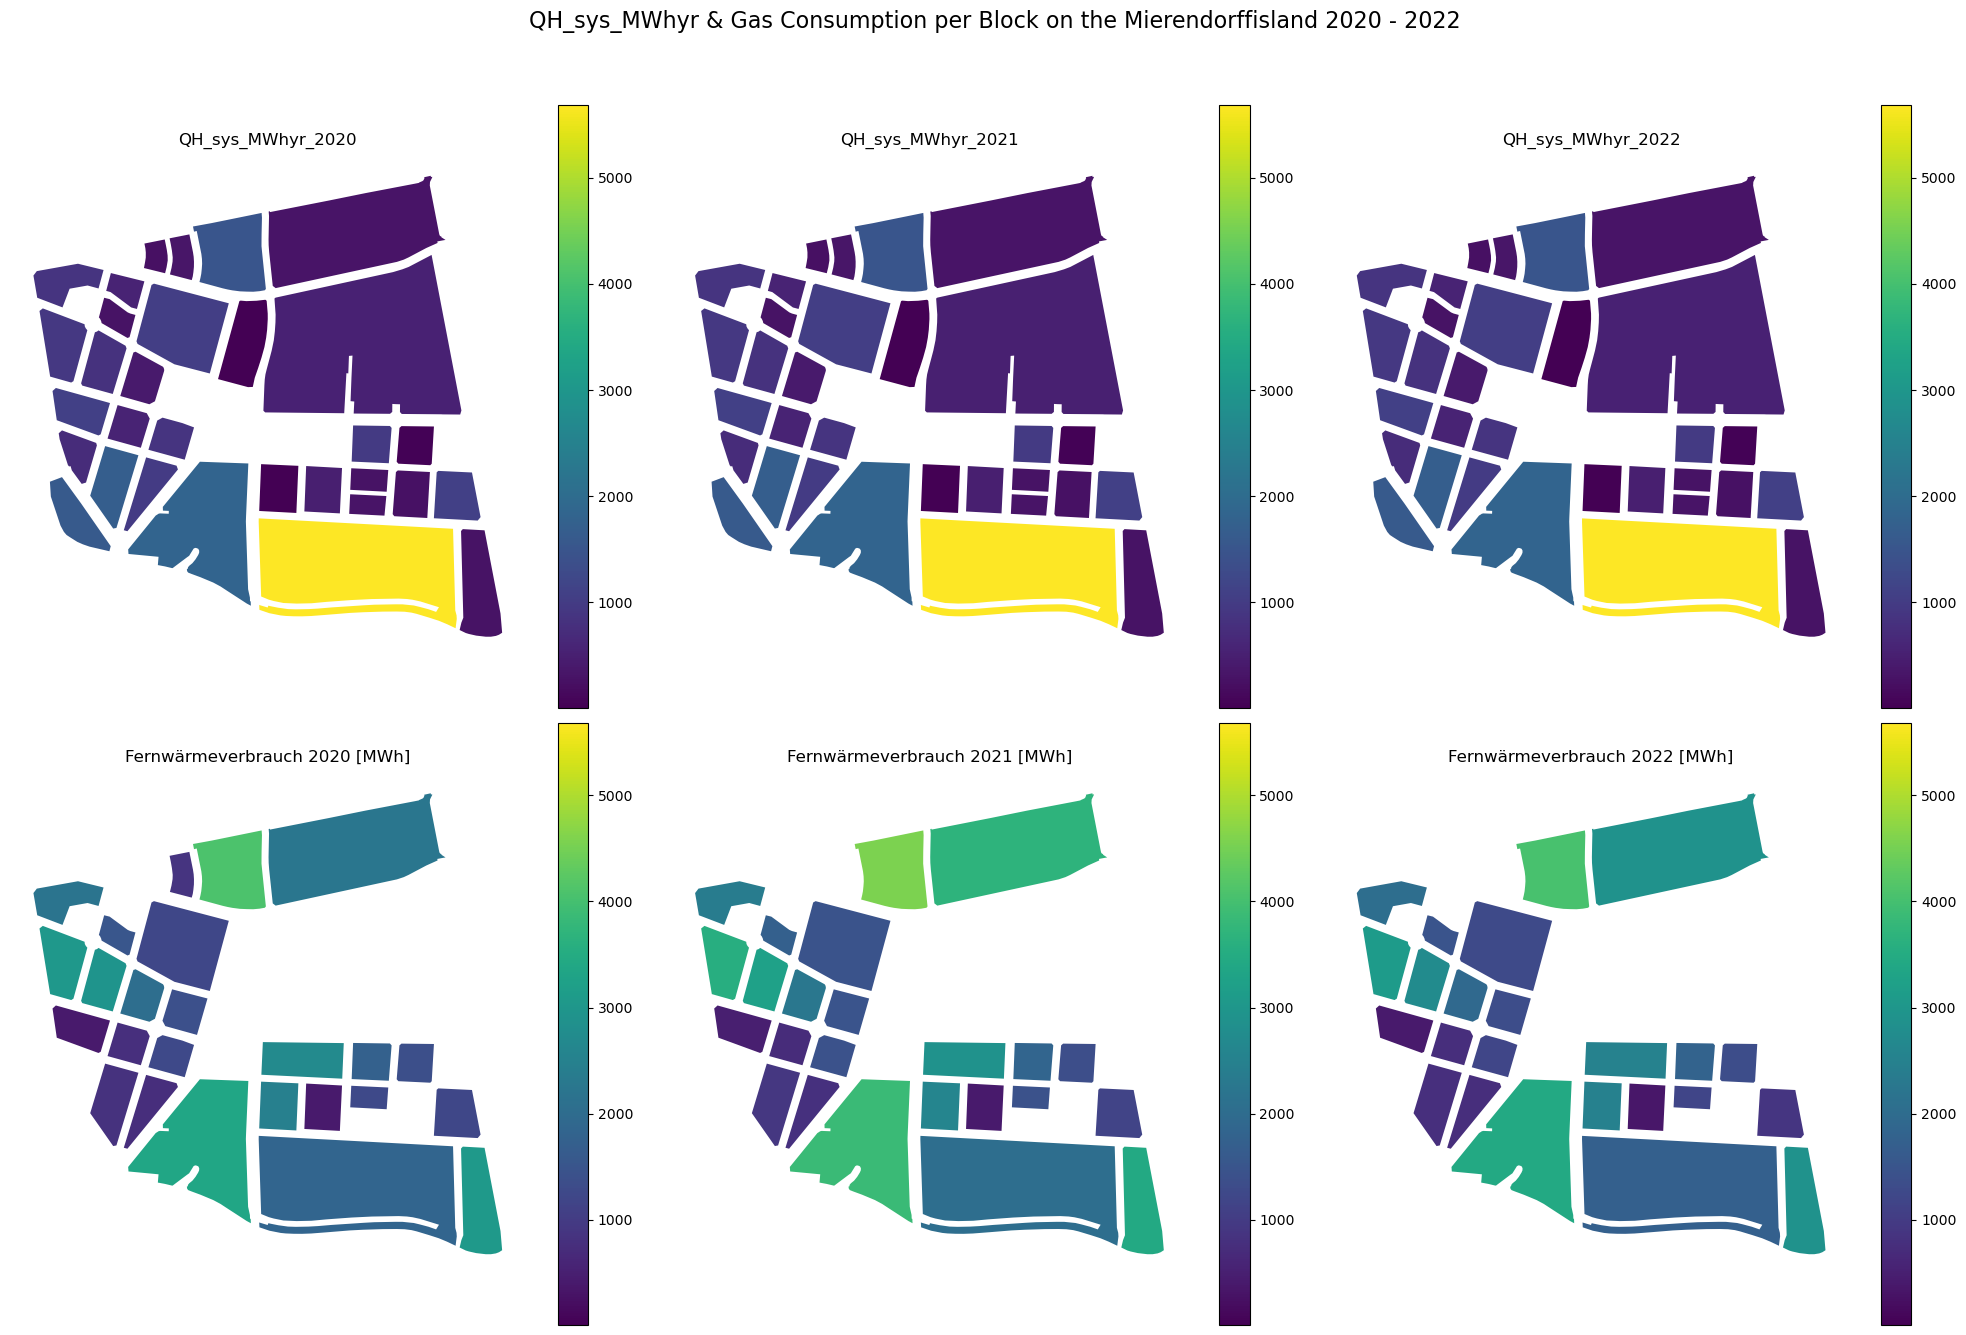

In [35]:
from matplotlib.colors import Normalize



# Assuming simulation_merged_gdf and measured_merged_gdf are defined GeoDataFrames
# Calculate vmin and vmax for normalization across all plots
vmin = min(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].min().min(),
           dh_data_shapes[dh_columns_to_check].min().min())
vmax = max(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].max().max(),
           dh_data_shapes[dh_columns_to_check].max().max())

# Define a normalization for the color mapping
norm = Normalize(vmin=vmin, vmax=vmax)

# Set up the figure for subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(20, 14))  # Adjusted to 2 rows


# Create the color map
cmap = plt.cm.viridis


# Plotting QH_sys_MWhyr 2020, 2021, 2022 in the first row
columns = ['QH_sys_MWhyr_2020', 'QH_sys_MWhyr_2021', 'QH_sys_MWhyr_2022']
for i, column in enumerate(columns):
    simulation_merged_gdf.plot(column=column, ax=axs[0, i], legend=True, cmap=cmap, norm=norm)
    axs[0, i].set_title(f'{column}')
    axs[0, i].axis('off')

# Plotting gas consumption for 2020, 2021, 2022 in the second row

for i, column in enumerate(dh_columns_to_check):
    dh_data_shapes.plot(column=column, ax=axs[1, i], legend=True, cmap=cmap, norm=norm)
    axs[1, i].set_title(f'{column}')
    axs[1, i].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('QH_sys_MWhyr & Gas Consumption per Block on the Mierendorffisland 2020 - 2022', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

Column QH_sys_MWhyr_2020 or Fernwärmeverbrauch 2020 [MWh] contains NaN values
Column QH_sys_MWhyr_2021 or Fernwärmeverbrauch 2021 [MWh] contains NaN values
Column QH_sys_MWhyr_2022 or Fernwärmeverbrauch 2022 [MWh] contains NaN values


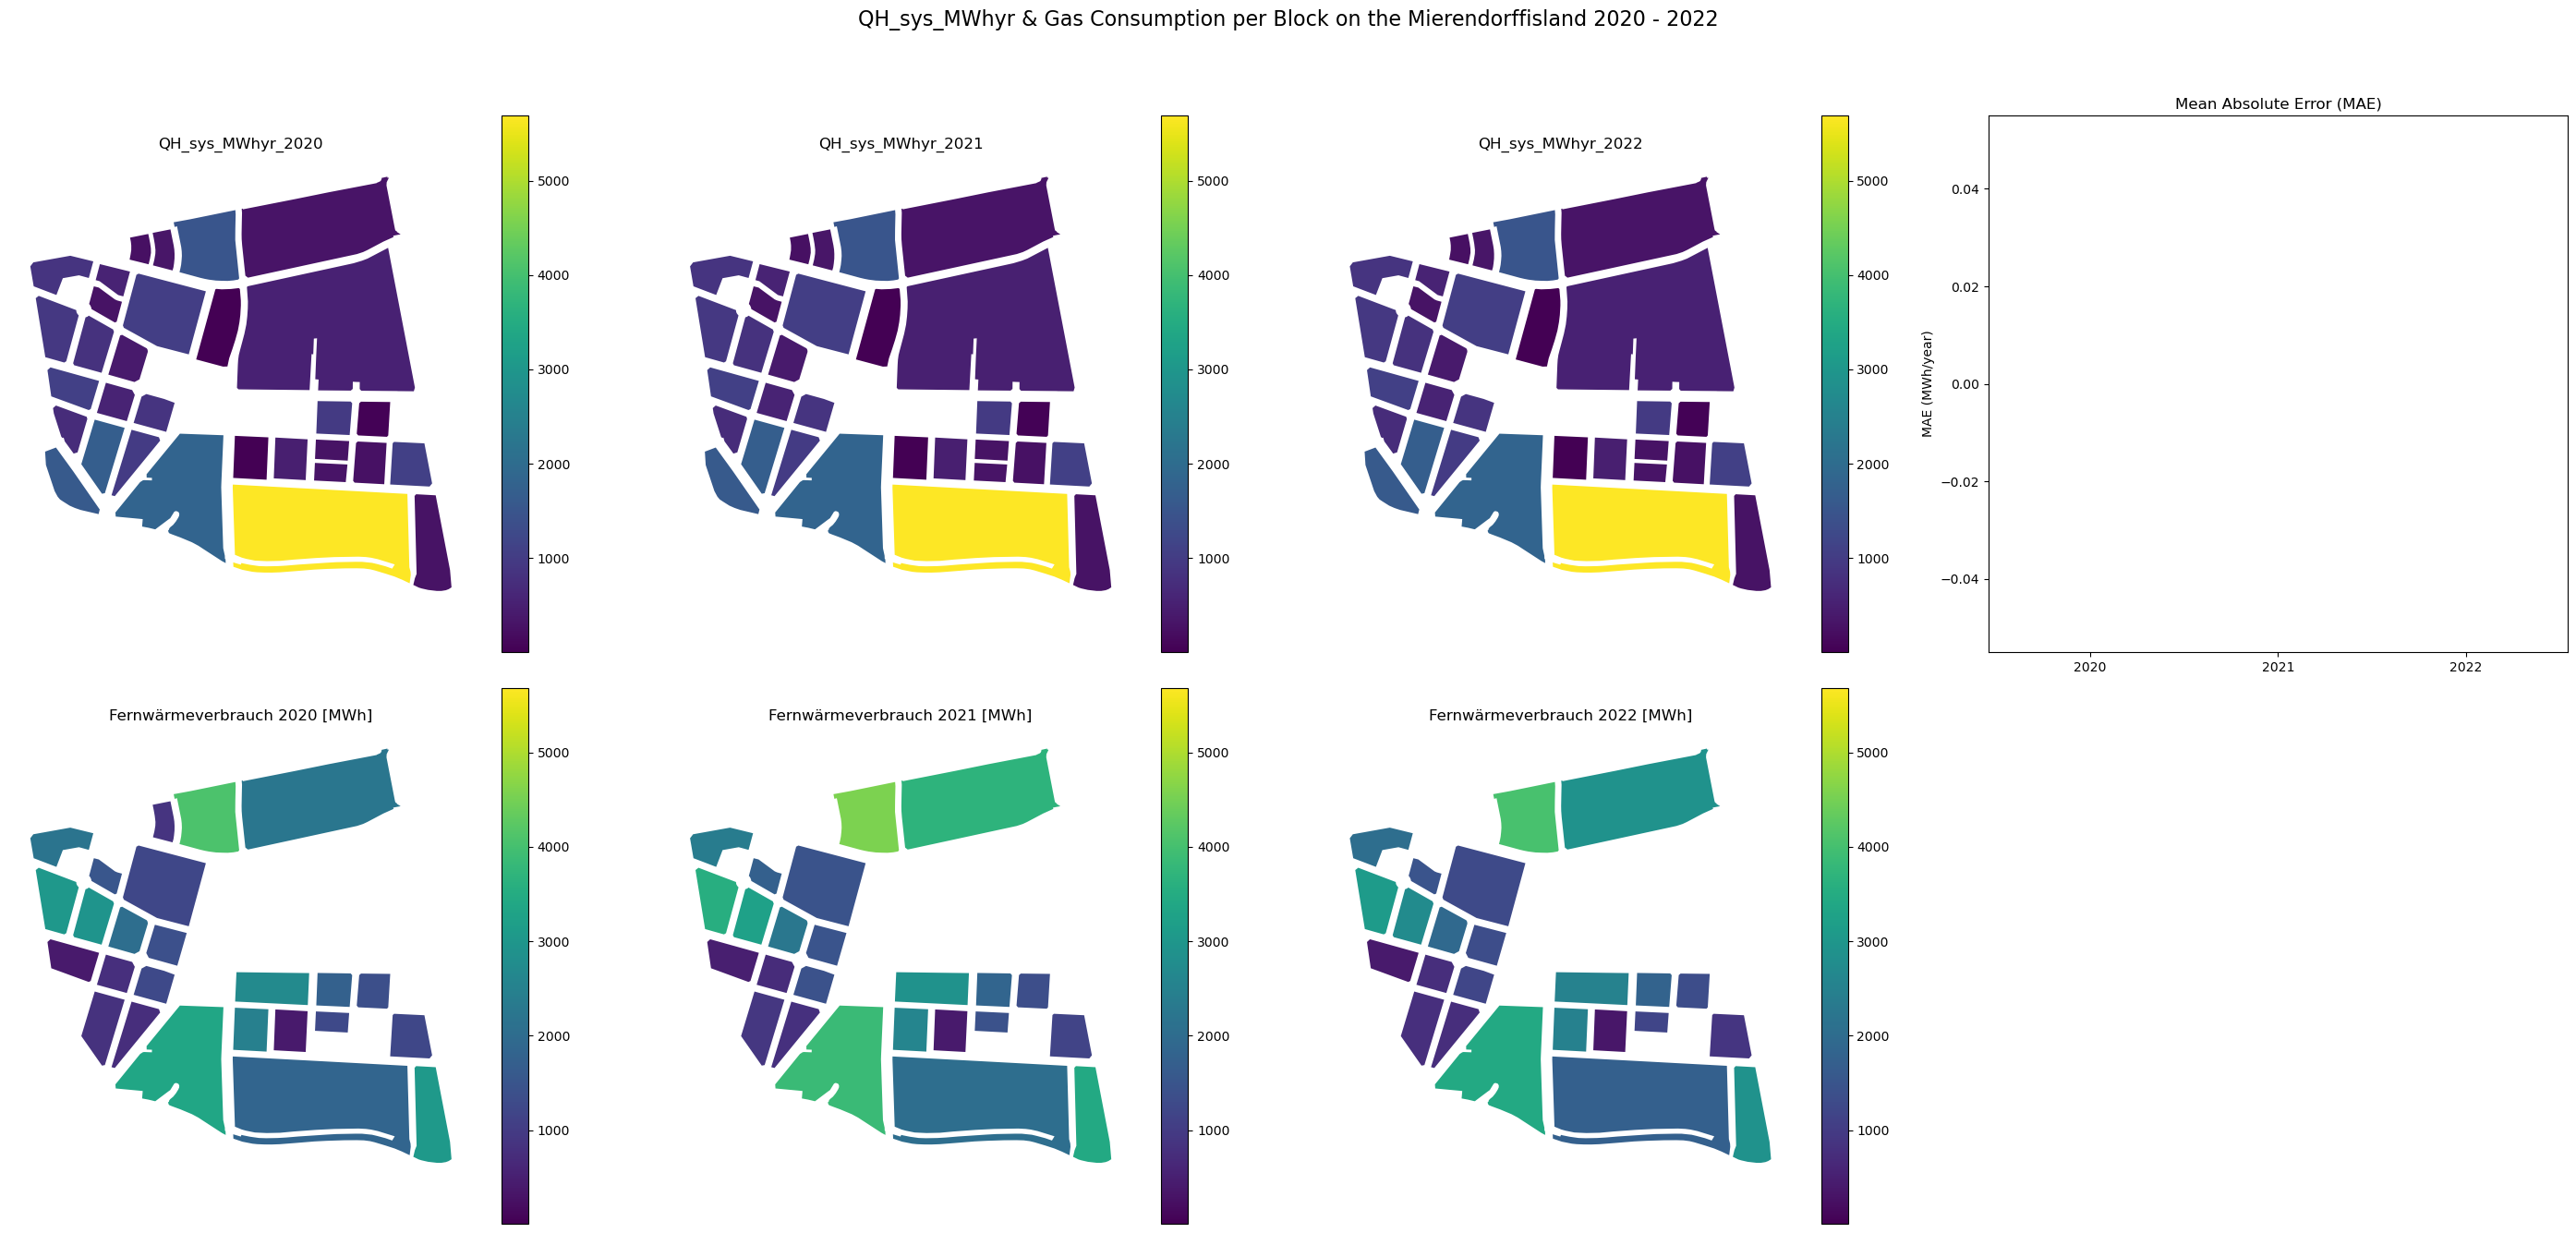

In [41]:
# Assuming simulation_merged_gdf and measured_merged_gdf are defined GeoDataFrames
# Calculate vmin and vmax for normalization across all plots
vmin = min(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].min().min(),
           dh_data_shapes[dh_columns_to_check].min().min())
vmax = max(simulation_merged_gdf[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]].max().max(),
           dh_data_shapes[dh_columns_to_check].max().max())

# Define a normalization for the color mapping
norm = Normalize(vmin=vmin, vmax=vmax)

# Set up the figure for subplots (2 rows, 4 columns)
fig, axs = plt.subplots(2, 4, figsize=(28, 14))  # Adjusted to 2 rows and 4 columns

# Create the color map
cmap = plt.cm.viridis

# Plotting QH_sys_MWhyr 2020, 2021, 2022 in the first row
columns_sim = ['QH_sys_MWhyr_2020', 'QH_sys_MWhyr_2021', 'QH_sys_MWhyr_2022']
for i, column in enumerate(columns_sim):
    simulation_merged_gdf.plot(column=column, ax=axs[0, i], legend=True, cmap=cmap, norm=norm)
    axs[0, i].set_title(f'{column}')
    axs[0, i].axis('off')

# Plotting gas consumption for 2020, 2021, 2022 in the second row
for i, column in enumerate(dh_columns_to_check):
    dh_data_shapes.plot(column=column, ax=axs[1, i], legend=True, cmap=cmap, norm=norm)
    axs[1, i].set_title(f'{column}')
    axs[1, i].axis('off')

# Calculate and plot MAE for each year in the fourth column
mae_values = []
# check for nan first 
for sim_col, meas_col in zip(columns_sim, dh_columns_to_check):
    if simulation_merged_gdf[sim_col].isnull().values.any() or dh_data_shapes[meas_col].isnull().values.any():
        print(f"Column {sim_col} or {meas_col} contains NaN values")
        mae_values.append(0)
        continue
    else:
        mae = mean_absolute_error(dh_data_shapes[meas_col], simulation_merged_gdf[sim_col])
        mae_values.append(mae)
        

# Plot MAE bar chart
years = ['2020', '2021', '2022']
axs[0, 3].bar(years, mae_values, color='purple')
axs[0, 3].set_title('Mean Absolute Error (MAE)')
axs[0, 3].set_ylabel('MAE (MWh/year)')

# Hide the fourth subplot in the second row
axs[1, 3].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('QH_sys_MWhyr & Gas Consumption per Block on the Mierendorffisland 2020 - 2022', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

# Show plot
plt.show()


In [44]:
# Assuming 'block_id' is the column that identifies the block in both DataFrames
block_ids = simulation_merged_gdf['blknr'].unique()

# Initialize a dictionary to store MAE values for each block
blockwise_mae_values = {}

# Iterate through each block
for block_id in block_ids:
    blockwise_mae_values[block_id] = []
    for sim_col, meas_col in zip(columns_sim, dh_columns_to_check):
        # Filter data for the current block
        sim_data_block = simulation_merged_gdf[simulation_merged_gdf['blknr'] == block_id]
        meas_data_block = dh_data_shapes[dh_data_shapes['blknr'] == block_id]
        
        # Check for NaN values in the filtered data
        if sim_data_block[sim_col].isnull().values.any() or meas_data_block[meas_col].isnull().values.any():
            print(f"Block {block_id}: Column {sim_col} or {meas_col} contains NaN values")
            blockwise_mae_values[block_id].append(0)
            continue
        else:
            # Calculate MAE for the current block and append it to the block's MAE list
            mae = mean_absolute_error(meas_data_block[meas_col], sim_data_block[sim_col])
            blockwise_mae_values[block_id].append(mae)

# Optionally, convert the blockwise MAE values dictionary to a DataFrame for easier analysis and visualization
import pandas as pd
blockwise_mae_df = pd.DataFrame.from_dict(blockwise_mae_values, orient='index', columns=[f"MAE_{col}" for col in dh_columns_to_check])
print(blockwise_mae_df)

ValueError: Found input variables with inconsistent numbers of samples: [0, 1]